#Set Up Code Options

In [1]:
!pip install pyproj

     |████████████████████████████████| 10.4MB 2.8MB/s 


In [0]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj

In [0]:
#This line will have the full data set printed out. 
#Toggle off and clear output if you no longer want to see full dataset
#pd.set_option("display.max_rows", None, "display.max_columns", None)

#read in the csv
raw_csv = 'https://raw.githubusercontent.com/dbabrams/ShallowDolomite_Group/master/Pumpage_Data_WillCounty.csv?token=ANYMEMJFLCWEXHTMSZRZIF26VSG72'

In [0]:
'''Will County'''
sw_lat =  41.41 #southwest latitude
sw_long = -88.24 #southwest longitude
ne_lat =  41.72 #northeast latitude
ne_long = -88.03 #northeast longitude


illimap = {'proj': 'lcc', # Lambert Conformal Conic
     'ellps': 'clrk66',
     'lon_0': -89.5,
     'lat_0': 33,
     'lat_1': 33,
     'lat_2': 45,
     'x_0': 2999994*0.3048,
     'y_0': 0}

prj = pyproj.Proj(illimap)

wgs84 = pyproj.Proj("epsg:4326")

nex, ney = pyproj.transform(wgs84,illimap,ne_lat,ne_long)
swx, swy = pyproj.transform(wgs84,illimap,sw_lat,sw_long)


nex, ney = round(nex/0.3048,-4), round(ney/0.3048,-4)
swx, swy = round(swx/0.3048,-4), round(swy/0.3048,-4)

#Raw Data

In [5]:
#Create a copy of the data is not edited
#This will be needed for McK for 3d
raw_data = pd.read_csv(raw_csv)
#print(raw_data)

print('size of original dataframe')
print(raw_data.shape)

size of original dataframe
(675, 46)


##Remove Lost and Deep Wells

In [6]:
#read in raw data 
raw_data_1 = pd.read_csv(raw_csv)

#drop rows if the depth, lamx, or lamy is unknown
raw_data_1.dropna(subset=['depth_total_last_known', 'lam_x', 'lam_y'], inplace = True)
    
#with this line I am dropping all of the rows that are deep wells (>400 ft)
raw_data_1.drop(raw_data_1[raw_data_1['depth_total_last_known'] > 400].index, inplace = True)

#hard code drop Channahon Park District Well 3 which has ______ for lam_x / lam_y & so dropna didn't work
raw_data_1.drop(raw_data_1[raw_data_1['p_num'] == 404003].index, inplace = True)

print('size of updated dataframe')
print(raw_data_1.shape)
#raw_data_1

size of updated dataframe
(335, 46)


In [0]:
#remove wells outside model domain
raw_data_1=raw_data_1.astype({'lam_x': 'float64','lam_y':'float64'})
raw_data_1=raw_data_1.loc[raw_data_1['lam_x']<nex]
raw_data_1=raw_data_1.loc[raw_data_1['lam_y']<ney]
raw_data_1=raw_data_1.loc[raw_data_1['lam_x']>swx]
raw_data_1=raw_data_1.loc[raw_data_1['lam_y']>swy]

##Arrange Data and only keep Big Wells

In [8]:
#raw_data_2 provides all of the old data but combined by facility
#reset index to be based on well owner
raw_data_2=raw_data_1.set_index('owner')
#delete extra rows so that the dataframe will just be owner and the years of pumping
raw_data_2=raw_data_2.drop(['p_num','isws_facility_id', 'fac_well_num','depth_total_last_known', 'lam_x', 'lam_y'], axis=1)
#sum together all pumping for the same well owners so that the dataset is by pumping by facility
raw_data_2=raw_data_2.groupby(level=0).sum(min_count=1)

#calculate the maximum pumping for each facility
raw_data_2['max']=raw_data_2[['1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']].max(axis=1) 

#List facilities in order of largest pumpers to smallest
raw_data_2=raw_data_2.sort_values(by='max',ascending=False)

#remove all facilities with nan in max and where maximum well pumping is less than 0.1mgd / "small fry" wells
raw_data_3=raw_data_2.dropna(subset=['max'],axis=0)
raw_data_3['small']=raw_data_3['max']-36524250
raw_data_4=raw_data_3[raw_data_3.small > 0]

#drop extra columns so that the dataframe will just be owner and the years of pumping
raw_data_4=raw_data_4.drop(['small', 'max'], axis=1)

print(raw_data_4)
print('size of updated dataframe')
print(raw_data_4.shape)

                                                  1981  ...         2019
owner                                                   ...             
HANSON MATERIAL SERVICE - YARD 61            8200000.0  ...          NaN
ILLINOIS AMERICAN - WEST SUBURBAN DIV      919209000.0  ...          NaN
ROMEOVILLE                                 157714600.0  ...          NaN
CREST HILL                                 359102900.0  ...          NaN
SHOREWOOD                                   84764800.0  ...  179934000.0
BOLINGBROOK                                180009000.0  ...          NaN
MINOOKA                                            0.0  ...          NaN
AQUA ILLINOIS - OAKVIEW                      7859520.0  ...          NaN
VULCAN MATERIAL - JOLIET 340                       NaN  ...          NaN
ROCKDALE                                           NaN  ...          NaN
LOCKPORT                                           NaN  ...          NaN
WILL COUNTY FOREST PRESERVE                11000000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
raw_data_4.to_csv('M1_3d_BigWells')

In [18]:
#read in cooked data (edited in excel)
cooked_data=pd.read_csv('https://raw.githubusercontent.com/dbabrams/ShallowDolomite_Group/pumping/caleb/M1_3d_BigWells_Edit.csv?token=ANYMEMJODKAAGVI22HLCU6S6VX5HU',index_col='owner')
print(cooked_data)

                                            1981  ...       2019
owner                                             ...           
HANSON MATERIAL SERVICE - YARD 61        8200000  ...     260833
ILLINOIS AMERICAN - WEST SUBURBAN DIV  919209000  ...    1114167
ROMEOVILLE                             157714600  ...  958571800
CREST HILL                             359102900  ...  792918333
SHOREWOOD                               84764800  ...  179934000
BOLINGBROOK                            180009000  ...          0
MINOOKA                                        0  ...   46300333
VULCAN MATERIAL - JOLIET 340                   0  ...  141300000
ROCKDALE                                24823840  ...   77497867

[9 rows x 39 columns]


In [0]:
#Put raw data in individual variables to plot

ILAr=raw_data_4.iloc[1]
ROMr=raw_data_4.iloc[2]
CRHr=raw_data_4.iloc[3]
SHOr=raw_data_4.iloc[4]
BOLr=raw_data_4.iloc[5]
MKAr=raw_data_4.iloc[6]
VMTr=raw_data_4.iloc[8]
ROKr=raw_data_4.iloc[9]

In [0]:
#put cooked data in individual variables to plot

ILAc=cooked_data.iloc[1]
ROMc=cooked_data.iloc[2]
CRHc=cooked_data.iloc[3]
SHOc=cooked_data.iloc[4]
BOLc=cooked_data.iloc[5]
MKAc=cooked_data.iloc[6]
VMTc=cooked_data.iloc[7]
ROKc=cooked_data.iloc[8]

##Wiki Graphs

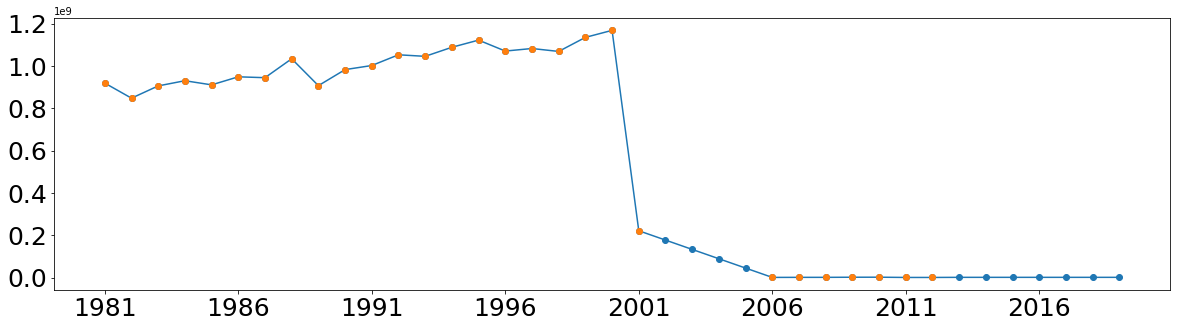

In [25]:
#plot Illinois American
ILAc.plot(label='owner', figsize=(20,5), fontsize=25, style='o-')
ILAr.plot(style='o')
plt.show()